## 1 示例代码

The minimum loss: 0.205229714512825 epoch: 283


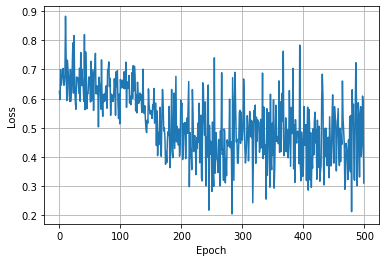

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class DiabetesDataset(Dataset):
    def __init__(self, filepath):
        xy = np.loadtxt(filepath, delimiter=',', dtype=np.float32)  # 加载数据
        self.len = xy.shape[0]  # 样本数量
        self.x_data = torch.from_numpy(xy[:, :-1])
        self.y_data = torch.from_numpy(xy[:, [-1]])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = DiabetesDataset("../Data/diabetes.csv.gz")  #实例化数据集对象
train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True,  # 打乱
                          num_workers=0)  # 多进程,设置2我会报错


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(8, 6)  # 输入维度为8，即特征数。输出维度为6
        self.linear2 = torch.nn.Linear(6, 4)
        self.linear3 = torch.nn.Linear(4, 1)
        self.activate = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.activate(self.linear1(x))
        x = self.activate(self.linear2(x))
        x = self.activate(self.linear3(x))  # 经过三层的变换
        return x


model = Model()

criterion = torch.nn.BCELoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss_list = []

if __name__ == '__main__':
    for epoch in range(500):
        loss = torch.tensor([])
        for i, (inputs, labels) in enumerate(train_loader, 0):
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            # print(epoch, i, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
    print("The minimum loss:", min(loss_list), 'epoch:', loss_list.index(min(loss_list)))
    plt.plot(loss_list)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

很抽象的图像，不过问题不大，我们来测试一下准确性，为了严谨起见，需要划分训练集和测试集，我们只需在原代码的基础上修改一下即可：

In [55]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

data = np.loadtxt('../Data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
print("data.shape:", data.shape)
# 划分训练集与测试集
X_train, X_test, Y_train, Y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=46)
x_test = torch.tensor(X_test)
y_test = torch.tensor(Y_test).reshape(Y_test.shape[0], 1)  # 转成二维


class DiabetesDataset(Dataset):
    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = torch.tensor(x)
        self.y_data = torch.tensor(y).reshape(y.shape[0], 1)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = DiabetesDataset(X_train, Y_train)  #实例化数据集对象
train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True,  # 打乱
                          num_workers=0)  # 多进程


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(8, 6)  # 输入维度为8，即特征数。输出维度为6
        self.linear2 = torch.nn.Linear(6, 4)
        self.linear3 = torch.nn.Linear(4, 1)
        self.activate = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.activate(self.linear1(x))
        x = self.activate(self.linear2(x))
        x = self.activate(self.linear3(x))
        return x


model = Model()

criterion = torch.nn.BCELoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

if __name__ == '__main__':
    # 开始训练
    for epoch in range(2000):
        loss = torch.tensor([])
        for i, (inputs, labels) in enumerate(train_loader, 0):
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 测试模型准确度
    test_pred = model(x_test)  # 返回的是概率，我们以0.5为阈值，大于0.5的认为预测为1
    y_pred_label = torch.where(test_pred >= 0.5, torch.tensor([1.0]), torch.tensor([0.0]))
    score = torch.eq(y_pred_label, y_test).sum().item() / y_test.size(0)
    print("test accuracy:", score)

data.shape: (759, 9)
test accuracy: 0.7631578947368421


竟然才这么点准确率，我宣布这个模型得不到我的认可。

## 2 加载自带数据集操作

In [13]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST(root='../P6 逻辑斯谛回归/data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=False)  # 在P6 逻辑斯谛回归中我已下载，这里直接读取即可
test_dataset = datasets.MNIST(root='../P6 逻辑斯谛回归/data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=False)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=32,
                         shuffle=False)  # 测试集设置为False，方便观察结果
for epoch in range(100):
    for batch_idx, (inputs, target) in enumerate(train_loader):
        break  # 这里的就跟前面一样了
    break

## 3 泰坦尼克号作业
这里**主要练习使用Dataset, DataLoader加载数据集**操作，准确率不是重点。因为准确率很大一部分依赖于数据处理、特征工程，为了方便我这里就直接把字符型数据删去了（实际中不能简单删去）。下面只加载train.csv，并把其划分为**训练集**和**验证集**，最后测试模型在验证集上的准确率，就不去预测网站提供的测试集了，因为还得提交才知道分数。


In [68]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

data = pd.read_csv('../Data/titanic/train.csv')
data.head()  #查看前五行

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
# 删去字符型特征,并转换成float32浮点型
data = data.drop(["Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1).astype('float32')
data.fillna(data.mean(), inplace=True)
print("data.shape:", data.shape)
data.head()

data.shape: (891, 7)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.250000
1,2.0,1.0,1.0,38.0,1.0,0.0,71.283302
2,3.0,1.0,3.0,26.0,0.0,0.0,7.925000
3,4.0,1.0,1.0,35.0,1.0,0.0,53.099998
4,5.0,0.0,3.0,35.0,0.0,0.0,8.050000


In [73]:
# 划分训练集与测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:, [0, 2, 3, 4, 5, 6]], data.iloc[:, 1],
                                                    test_size=0.3,
                                                    random_state=32)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
x_test = torch.tensor(np.array(X_test))
y_test = torch.tensor(np.array(Y_test).reshape(Y_test.shape[0], 1))  # 转成二维


class TitanicDataset(Dataset):
    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = torch.tensor(x)
        self.y_data = torch.tensor(y).reshape(y.shape[0], 1)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = TitanicDataset(X_train, Y_train)  #实例化数据集对象
train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True,  # 打乱
                          num_workers=0)  # 多进程


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(6, 4)  # 输入维度为6，即特征数。输出维度为4
        self.linear2 = torch.nn.Linear(4, 2)
        self.linear3 = torch.nn.Linear(2, 1)
        self.activate = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.activate(self.linear1(x))
        x = self.activate(self.linear2(x))
        x = self.activate(self.linear3(x))
        return x


model = Model()

criterion = torch.nn.BCELoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=0.15)

if __name__ == '__main__':
    # 开始训练
    for epoch in range(500):
        loss = torch.tensor([])
        for i, (inputs, labels) in enumerate(train_loader, 0):
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 测试模型准确度
    test_pred = model(x_test)  # 返回的是概率，我们以0.5为阈值，大于0.5的认为预测为1
    y_pred_label = torch.where(test_pred >= 0.5, torch.tensor([1.0]), torch.tensor([0.0]))
    score = torch.eq(y_pred_label, y_test).sum().item() / y_test.size(0)
    print("test accuracy:", score)

test accuracy: 0.6119402985074627


不进行数据预处理果然很烂！后续再进行优化。